<h2 style="font-weight: 700; text-align: center">Autoencoders and PCA</h2>

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Input,Dense
from keras.models import Model

#### Loading the Dataset - IRIS

In [50]:
iris = load_iris()
X = iris.data
Y = iris.target

In [51]:
X = pd.DataFrame(X)
X.columns = ['X0', 'X1', 'X2', 'X3']

In [52]:
X.head()

,X0,X1,X2,X3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


#### Normalizing the input values
###### MinMax Scaler

In [53]:
sc = MinMaxScaler(feature_range=(0,1))
X_scaled = sc.fit_transform(X)

In [54]:
X_scaled_train = X_scaled[: int(X_scaled.shape[0]*0.8), :]
X_scaled_test = X_scaled[int(X_scaled.shape[0]*0.8):, :]


#### Utility Graph printer

In [55]:
def graph(test, pred):
    n = len(test[0])
    if n == 2:
        fig = plt.figure(figsize=(16, 5))
    else:
        fig = plt.figure(figsize=(16, 10))
    for i in range(1, n+1):
        if n == 2:
            fig.add_subplot(1, 2, i)
        else:
            fig.add_subplot(2, 2, i)
        plt.title('Predictions for X' + str(i))
        plt.plot(list(range(1, len(test)+1)),
                 [j[i-1] for j in test], marker='o', color='g')
        plt.plot(list(range(1, len(test)+1)),
                 [j[i-1] for j in pred], marker='o', color='r')
        plt.legend(['Testing Points',  'Predicted Points'], loc='best')

    plt.show()


#### Principal Component Analysis

In [56]:
pca = PCA(n_components = 3)
X_transformed = pca.fit_transform(X_scaled)

In [57]:
X_transformed_train = X_transformed[ : int(X_transformed.shape[0]*0.8)]
X_transformed_test = X_transformed[int(X_transformed.shape[0]*0.8) : ]

#### Observation 

plt.figure(figsize=(5,5))
for i in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[i,0], X_transformed[i, 1], color='r' if Y[i] == 0 else 'b')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

### AutoEncoder

In [59]:
input_dim = X_scaled.shape[1]

encoding_dim = 3

input_ = Input(shape=(input_dim,))

#### Linear Activation Function for AutoEncoder

In [60]:
encoded = Dense(encoding_dim,activation='linear')(input_) # 4 -> 3
decoded = Dense(input_dim,activation='linear')(encoded) # 3 -> 4

In [61]:
autoencoder = Model(input_, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_6 (Dense)             (None, 3)                 15        
                                                                 
 dense_7 (Dense)             (None, 4)                 16        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [62]:
history = autoencoder.fit(X_scaled_train, X_scaled_train, epochs=1000, batch_size=16, shuffle=True, validation_data=(X_scaled_test, X_scaled_test), verbose=0)

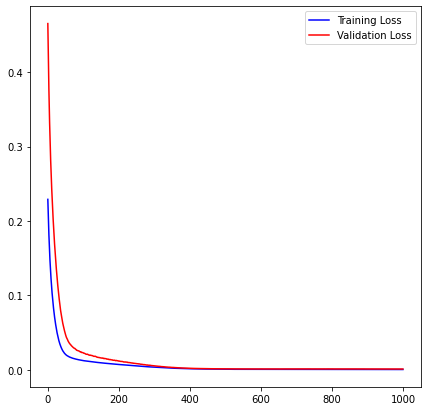

In [63]:
plt.figure(figsize=(7,7))
plt.plot(history.history['loss'], color='b')
plt.plot(history.history['val_loss'], color='r')
plt.legend(['Training Loss','Validation Loss'],loc='best')
plt.show()

In [64]:
X_scaled_pred = autoencoder.predict(X_scaled_test)

1/1 [==============================] - 0s 77ms/step


In [65]:
print(X_scaled_test[0])
print(X_scaled_pred[0])

[0.72222222 0.5        0.79661017 0.91666667]
[0.6884258  0.5157765  0.83376944 0.89158916]


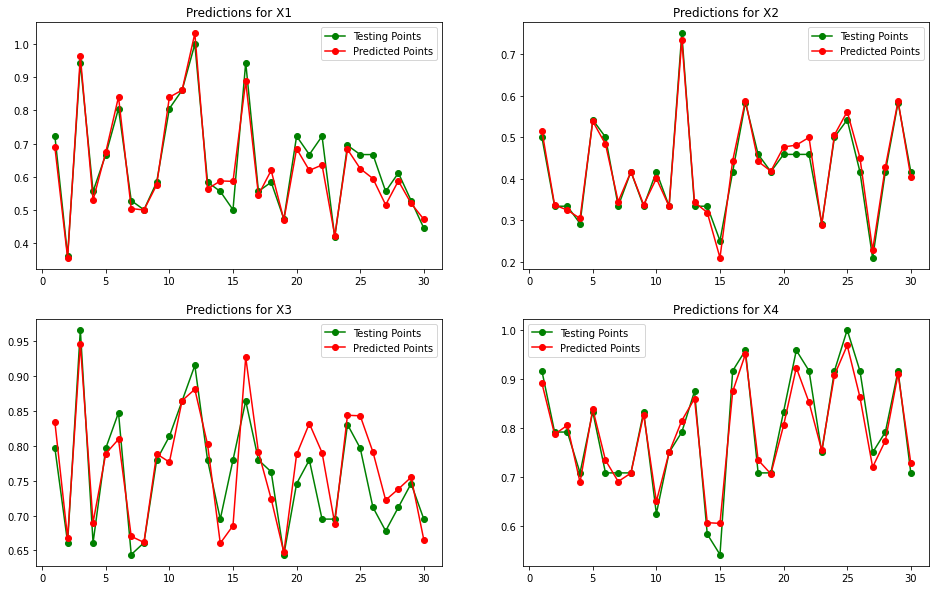

In [66]:
graph(X_scaled_test, X_scaled_pred)

##### Building an Encoder

In [67]:
encoder = Model(input_, encoded)
encoder.compile(optimizer='adam',loss='mse')
encoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_6 (Dense)             (None, 3)                 15        
                                                                 
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


In [68]:
history = encoder.fit(X_scaled_train, X_transformed_train, epochs=1000, batch_size=16, shuffle=True, validation_data=(X_scaled_test, X_transformed_test), verbose=0)

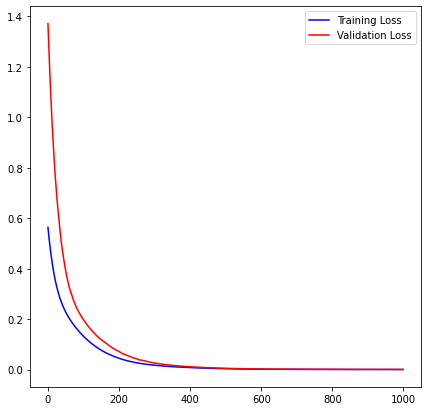

In [69]:
plt.figure(figsize=(7,7))
plt.plot(history.history['loss'], color='b')
plt.plot(history.history['val_loss'], color='r')
plt.legend(['Training Loss','Validation Loss'],loc='best')
plt.show()

In [70]:
X_transformed_pred = encoder.predict(X_scaled_test)

1/1 [==============================] - 0s 74ms/step


In [71]:
print(X_transformed_test[0])
print(X_transformed_pred[0])

[0.61473318 0.15356602 0.06908138]
[0.6440787  0.15314567 0.0599032 ]


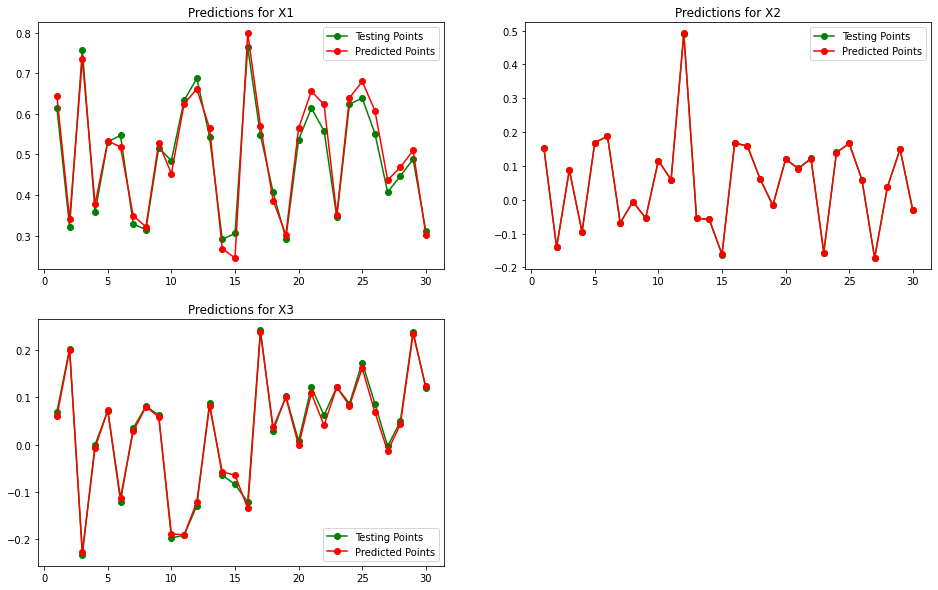

In [72]:
graph(X_transformed_test, X_transformed_pred)

#### Building a Decoder

In [73]:
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1] #3 -> 4

In [74]:
decoder = Model(encoded_input, decoder_layer(encoded_input))
decoder.compile(optimizer='adam',loss='mse')
decoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 16        
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


In [75]:
history = decoder.fit(X_transformed_train, X_scaled_train, epochs=1000, batch_size=16, shuffle=True, validation_data=(X_transformed_test, X_scaled_test), verbose=0)

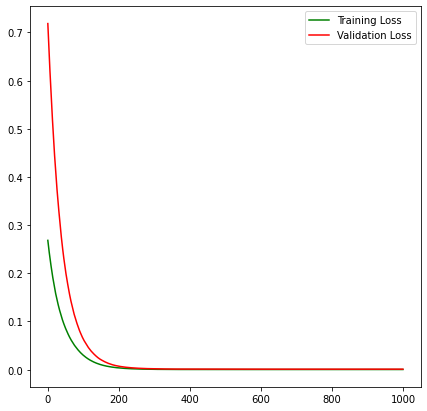

In [76]:
plt.figure(figsize=(7,7))
plt.plot(history.history['loss'], color='g')
plt.plot(history.history['val_loss'], color='r')
plt.legend(['Training Loss','Validation Loss'],loc='best')
plt.show()

In [77]:
X_scaled_pred = decoder.predict(X_transformed_test)

1/1 [==============================] - 0s 79ms/step


In [78]:
print(X_scaled_test[0])
print(X_scaled_pred[0])

[0.72222222 0.5        0.79661017 0.91666667]
[0.69960535 0.51321465 0.84592015 0.8881141 ]


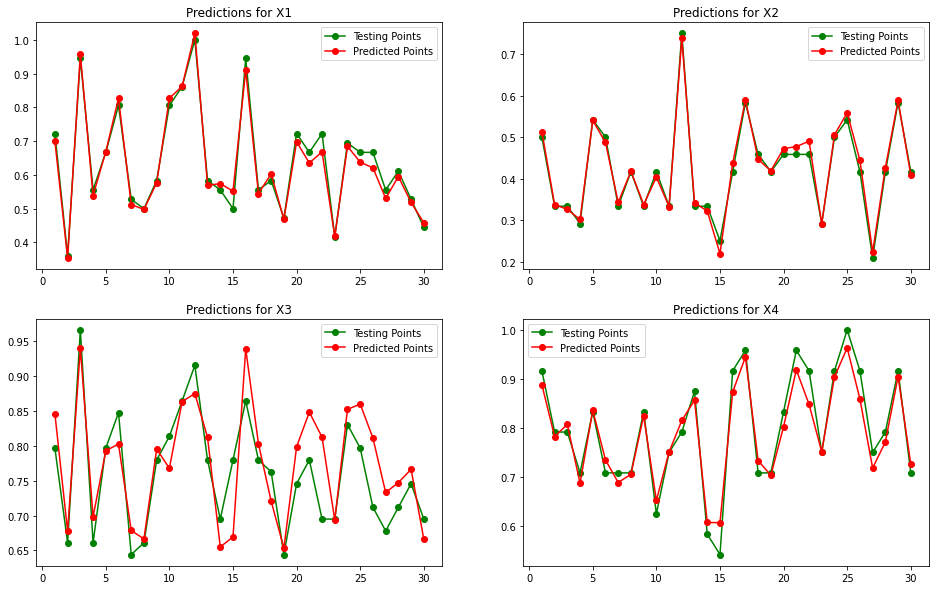

In [79]:
graph(X_scaled_test, X_scaled_pred)

#### Autoencoder with a non-linear activation function - Sigmoid

In [80]:
encoder = Dense(encoding_dim,activation='sigmoid')(input_) # 4 -> 2
decoder = Dense(input_dim,activation='sigmoid')(encoder) # 2 -> 4

In [81]:
autoencoder = Model(input_, decoder)
autoencoder.compile(optimizer='adam',loss='mse')
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_8 (Dense)             (None, 3)                 15        
                                                                 
 dense_9 (Dense)             (None, 4)                 16        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [82]:
history = autoencoder.fit(X_scaled_train, X_scaled_train, epochs=1000, batch_size=16, shuffle=True, validation_data=(X_scaled_test, X_scaled_test), verbose=0)

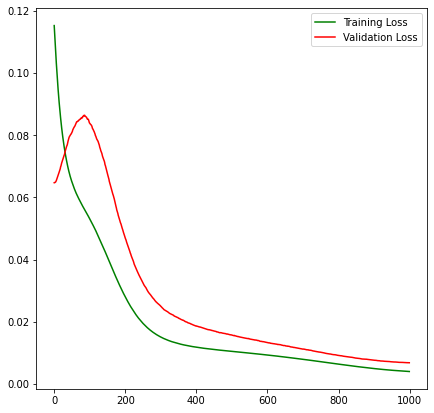

In [83]:
plt.figure(figsize=(7,7))
plt.plot(history.history['loss'], color='g')
plt.plot(history.history['val_loss'], color='r')
plt.legend(['Training Loss','Validation Loss'],loc='best')
plt.show()

In [84]:
X_scaled_pred = autoencoder.predict(X_scaled_test)

1/1 [==============================] - 0s 89ms/step


In [85]:
print(X_scaled_test[0])
print(X_scaled_pred[0])

[0.72222222 0.5        0.79661017 0.91666667]
[0.7366528  0.41050887 0.81034803 0.8077878 ]


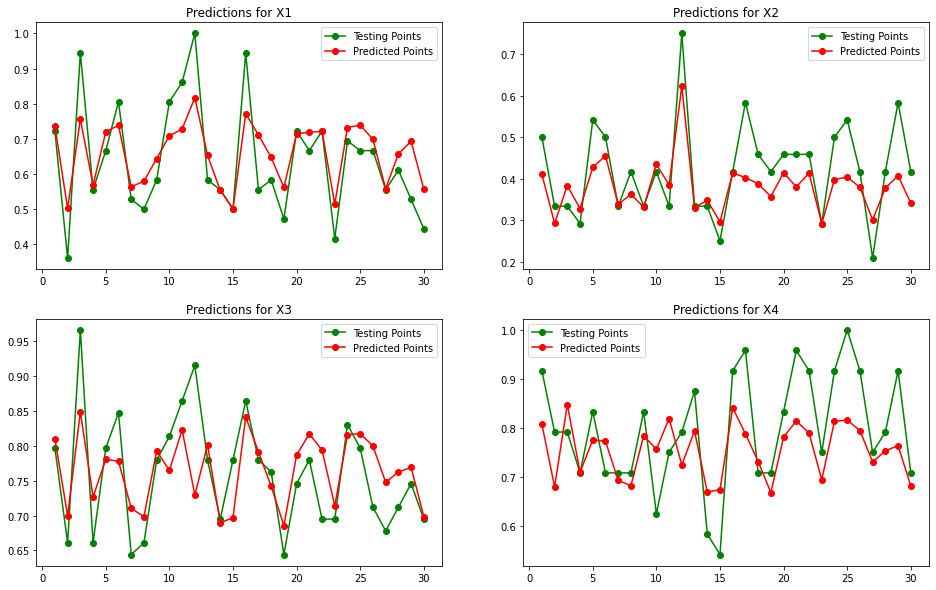

In [86]:
graph(X_scaled_test, X_scaled_pred)

#### Autoencoder with a non-linear activation function - ReLU

In [87]:
encoder = Dense(encoding_dim,activation='relu')(input_) # 4 -> 2
decoder = Dense(input_dim,activation='relu')(encoder) # 2 -> 4

In [88]:
autoencoder = Model(input_, decoder)
autoencoder.compile(optimizer='adam',loss='mse')
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_10 (Dense)            (None, 3)                 15        
                                                                 
 dense_11 (Dense)            (None, 4)                 16        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [89]:
history = autoencoder.fit(X_scaled_train, X_scaled_train, epochs=1000, batch_size=16, shuffle=True, validation_data=(X_scaled_test, X_scaled_test), verbose=0)

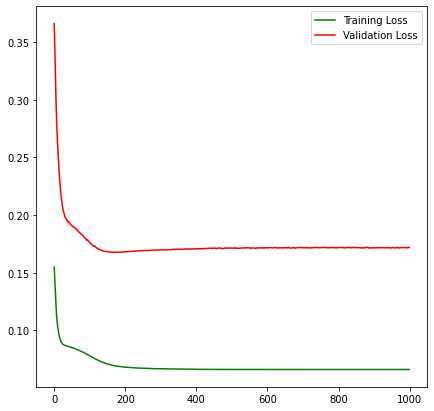

In [90]:
plt.figure(figsize=(7,7))
plt.plot(history.history['loss'], color='g')
plt.plot(history.history['val_loss'], color='r')
plt.legend(['Training Loss','Validation Loss'],loc='best')
plt.show()

In [91]:
X_scaled_pred = autoencoder.predict(X_scaled_test)

1/1 [==============================] - 0s 76ms/step


In [92]:
print(X_scaled_test[0])
print(X_scaled_pred[0])

[0.72222222 0.5        0.79661017 0.91666667]
[0.63282144 0.30178225 0.78439546 0.        ]


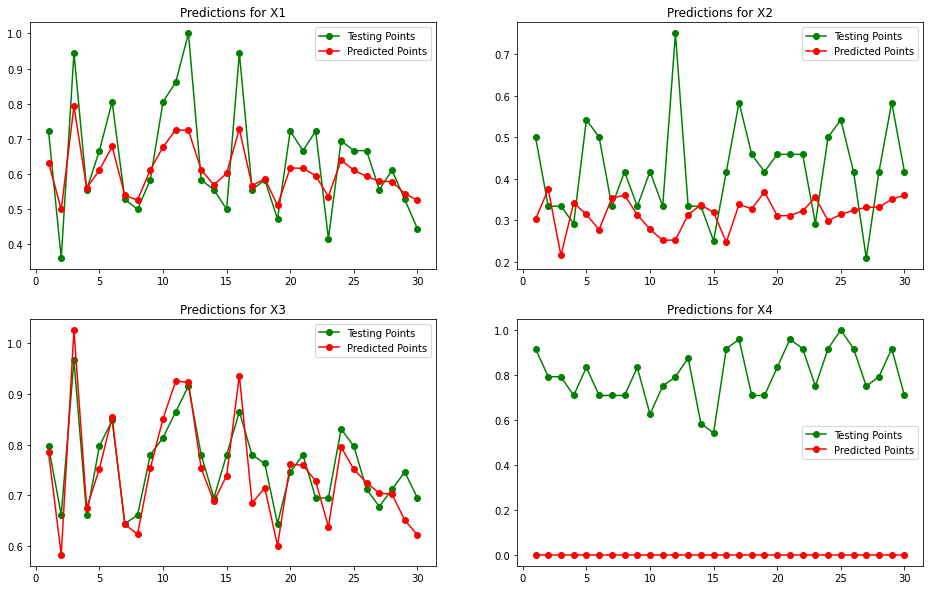

In [93]:
graph(X_scaled_test, X_scaled_pred)

#### Conclusion

##### Autoencoder work as PCA, when:

* Input and output are normalized.
* Linear Activation Functions used
* Loss Function -> MSE
* Autoencoder is undercomplete

